In [6]:
from IPython.core.display import display, HTML

### Widen notebook to fit browser window
display(HTML("<style>.container { width:100% !important; }</style>"))


Using already available cached classifier.

Overwriting cached classifier.
count_window: 125, count_car_window: 0


/home.net/rh17dur/miniconda3/envs/carnd-term1-gpu/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


count_window: 125, count_car_window: 6
count_window: 125, count_car_window: 3
count_window: 125, count_car_window: 1
count_window: 125, count_car_window: 9
count_window: 125, count_car_window: 4


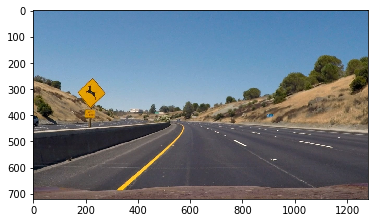

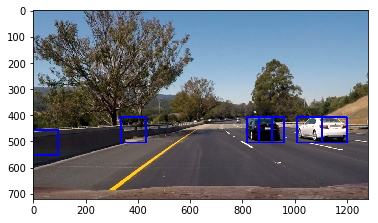

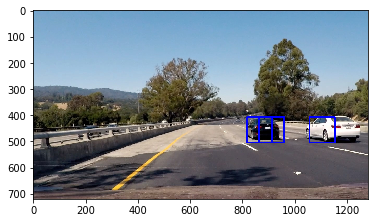

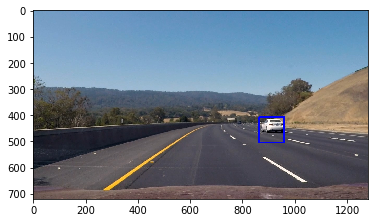

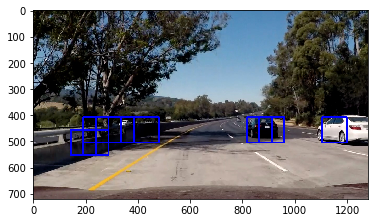

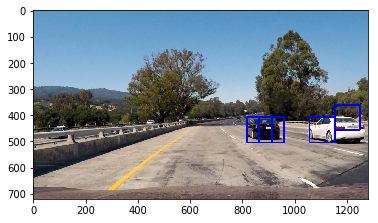

In [7]:
import os, glob
import pickle
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

from configuration import dict_config_params
from sliding_windows import search_windows, slide_window, draw_boxes, find_cars
from classifiers import get_training_data, fit_svm

def main():

    # Pickle dump classifier
    filename_classifier = "./classifiers_pickle.p"
    if (dict_config_params['use_cached_classifier'] is True and
        os.path.exists(filename_classifier)):
            print("\nUsing already available cached classifier.")
            svc, X_scaler = pickle.load( open(filename_classifier, "rb" ) )
    else:
        X, labels = get_training_data()    
        svc, X_scaler = fit_svm(X, labels, verbose=True)
        
    if dict_config_params['overwrite_cached_classifier']:
        print("\nOverwriting cached classifier.")
        pickle.dump([svc, X_scaler], open( filename_classifier, "wb" ) )
    
    # Test images    
    count_fig = 1
    filenames_img = glob.glob('./test_images/test*.jpg')
    for filename_img in filenames_img:
        image = mpimg.imread(filename_img)
        draw_image = np.copy(image)

        # Normalize image intensity, since we read in a jpg
        image = image.astype(np.float32)/255
        y_start_stop = [np.int(image.shape[0]/2), image.shape[0] - 60]
        
        if True:
            window_img = find_cars(image, y_start_stop, svc, X_scaler, scale=1)
        else:            
            windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                            xy_window=(96, 96), xy_overlap=(0.5, 0.5))

            hot_windows = search_windows(image, windows, svc, X_scaler)                       
            window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                

        #print("window_img.shape {}".format(window_img))
        plt.figure(count_fig)
        plt.imshow(window_img)
        count_fig += 1
    
    plt.show()
    
if __name__ == '__main__':
    main()